In [1]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt
from collections import Counter
import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from langdetect import detect
import string
import simplemma
import pyLDAvis
import pyLDAvis.gensim_models

### Open JSON File
Clean json data

In [2]:
with open('E:/Projects/Job analysis/data/Jobcards.json', "r") as json_file:
    cards_js = json.load(json_file)
    cards_df = pd.read_json(cards_js)
# Drop null
cards_df = cards_df.dropna()

# Replace backspaces with ""
for name in cards_df.columns:
    cards_df[name] = [a.replace("\n", "") for a in cards_df[name]]

# Select city as Location
cards_df["Location"] = [a.split()[0].replace(",", "") for a in cards_df["Location"]]

# Get info DF
cards_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        899 non-null    object
 1   Company      899 non-null    object
 2   Location     899 non-null    object
 3   Description  899 non-null    object
dtypes: object(4)
memory usage: 35.1+ KB


C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Quick check for "\n"
cards_df.head()

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Company,Location,Description
0,Senior Consultant in Data science ...,Sia Partners,Antwerpen,"As a senior consultant in Data Science, you w..."
1,Stage - Data Science,Argenta,Antwerpen,FunctieKlaar voor een eerste leerri...
2,Data Science Engineer Healthcare ...,Robovision,Gent,Geplaatst door Willem R...
3,Data Science Software Engineer ...,OMP,Gent,"We are OMP, a game changer that opt..."
4,Junior Market Analyst (FMCG) ...,GfK,Leuven,"For over 80 years, GfK has been a r..."


### Prepare data for NLP

In [4]:
# Add language and set description to lowercase
cards_df["Language"] = [detect(a) for a in cards_df["Description"]]
cards_df["Description"] = [a.lower() for a in cards_df["Description"]]
cards_df

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Company,Location,Description,Language
0,Senior Consultant in Data science ...,Sia Partners,Antwerpen,"as a senior consultant in data science, you w...",en
1,Stage - Data Science,Argenta,Antwerpen,functieklaar voor een eerste leerri...,nl
2,Data Science Engineer Healthcare ...,Robovision,Gent,geplaatst door willem r...,en
3,Data Science Software Engineer ...,OMP,Gent,"we are omp, a game changer that opt...",en
4,Junior Market Analyst (FMCG) ...,GfK,Leuven,"for over 80 years, gfk has been a r...",en
...,...,...,...,...,...
995,Finance Enterprise Partner,Roche,Brussel,a finance enterprise partner (fep) leverages ...,en
996,(Senior) Clinical Data Manager (CD...,SGS,Mechelen,"company descriptionat sgs, you can choose. fi...",en
997,Senior Clinical Project Management...,IQVIA,Antwerpen,job overviewsenior clinical project managemen...,en
998,Sales Manager Hospital Belux ...,IQVIA,Zaventem,hospital channelbuild relationship ...,en


In [5]:
# Create stopword lists
# Dutch Stop words
sw_nl = ["aan","aangaande","aangezien","achte","achter","achterna","af","afgelopen","al","aldaar","aldus","alhoewel","alias","alle","allebei","alleen","alles","als","alsnog","altijd","altoos","ander","andere","anders","anderszins","beetje","behalve","behoudens","beide","beiden","ben","beneden","bent","bepaald","betreffende","bij","bijna","bijv","binnen","binnenin","blijkbaar","blijken","boven","bovenal","bovendien","bovengenoemd","bovenstaand","bovenvermeld","buiten","bv","daar","daardoor","daarheen","daarin","daarna","daarnet","daarom","daarop","daaruit","daarvanlangs","dan","dat","de","deden","deed","der","derde","derhalve","dertig","deze","dhr","die","dikwijls","dit","doch","doe","doen","doet","door","doorgaand","drie","duizend","dus","echter","een","eens","eer","eerdat","eerder","eerlang","eerst","eerste","eigen","eigenlijk","elk","elke","en","enig","enige","enigszins","enkel","er","erdoor","erg","ergens","etc","etcetera","even","eveneens","evenwel","gauw","ge","gedurende","geen","gehad","gekund","geleden","gelijk","gemoeten","gemogen","genoeg","geweest","gewoon","gewoonweg","haar","haarzelf","had","hadden","hare","heb","hebben","hebt","hedden","heeft","heel","hem","hemzelf","hen","het","hetzelfde","hier","hierbeneden","hierboven","hierin","hierna","hierom","hij","hijzelf","hoe","hoewel","honderd","hun","hunne","ieder","iedere","iedereen","iemand","iets","ik","ikzelf","in","inderdaad","inmiddels","intussen","inzake","is","ja","je","jezelf","jij","jijzelf","jou","jouw","jouwe","juist","jullie","kan","klaar","kon","konden","krachtens","kun","kunnen","kunt","laatst","later","liever","lijken","lijkt","maak","maakt","maakte","maakten","maar","mag","maken","me","meer","meest","meestal","men","met","mevr","mezelf","mij","mijn","mijnent","mijner","mijzelf","minder","miss","misschien","missen","mits","mocht","mochten","moest","moesten","moet","moeten","mogen","mr","mrs","mw","na","naar","nadat","nam","namelijk","nee","neem","negen","nemen","nergens","net","niemand","niet","niets","niks","noch","nochtans","nog","nogal","nooit","nu","nv","of","ofschoon","om","omdat","omhoog","omlaag","omstreeks","omtrent","omver","ondanks","onder","ondertussen","ongeveer","ons","onszelf","onze","onzeker","ooit","ook","op","opnieuw","opzij","over","overal","overeind","overige","overigens","paar","pas","per","precies","recent","redelijk","reeds","rond","rondom","samen","sedert","sinds","sindsdien","slechts","sommige","spoedig","steeds","tamelijk","te","tegen","tegenover","tenzij","terwijl","thans","tien","tiende","tijdens","tja","toch","toe","toen","toenmaals","toenmalig","tot","totdat","tussen","twee","tweede","u","uit","uitgezonderd","uw","vaak","vaakwat","van","vanaf","vandaan","vanuit","vanwege","veel","veeleer","veertig","verder","verscheidene","verschillende","vervolgens","via","vier","vierde","vijf","vijfde","vijftig","vol","volgend","volgens","voor","vooraf","vooral","vooralsnog","voorbij","voordat","voordezen","voordien","voorheen","voorop","voorts","vooruit","vrij","vroeg","waar","waarom","waarschijnlijk","wanneer","want","waren","was","wat","we","wederom","weer","weg","wegens","weinig","wel","weldra","welk","welke","werd","werden","werder","wezen","whatever","wie","wiens","wier","wij","wijzelf","wil","wilden","willen","word","worden","wordt","zal","ze","zei","zeker","zelf","zelfde","zelfs","zes","zeven","zich","zichzelf","zij","zijn","zijne","zijzelf","zo","zoals","zodat","zodra","zonder","zou","zouden","zowat","zulk","zulke","zullen","zult"]

# English stop words
sw_en = list(STOPWORDS) + ["science", "data", "apply", "job", "datum", "year", "join"]

# French stop words
sw_fr = ["a","abord","absolument","afin","ah","ai","aie","aient","aies","ailleurs","ainsi","ait","allaient","allo","allons","allô","alors","anterieur","anterieure","anterieures","apres","après","as","assez","attendu","au","aucun","aucune","aucuns","aujourd","aujourd'hui","aupres","auquel","aura","aurai","auraient","aurais","aurait","auras","aurez","auriez","aurions","aurons","auront","aussi","autant","autre","autrefois","autrement","autres","autrui","aux","auxquelles","auxquels","avaient","avais","avait","avant","avec","avez","aviez","avions","avoir","avons","ayant","ayez","ayons","b","bah","bas","basee","bat","beau","beaucoup","bien","bigre","bon","boum","bravo","brrr","c","car","ce","ceci","cela","celle","celle-ci","celle-là","celles","celles-ci","celles-là","celui","celui-ci","celui-là","celà","cent","cependant","certain","certaine","certaines","certains","certes","ces","cet","cette","ceux","ceux-ci","ceux-là","chacun","chacune","chaque","cher","chers","chez","chiche","chut","chère","chères","ci","cinq","cinquantaine","cinquante","cinquantième","cinquième","clac","clic","combien","comme","comment","comparable","comparables","compris","concernant","contre","couic","crac","d","da","dans","de","debout","dedans","dehors","deja","delà","depuis","dernier","derniere","derriere","derrière","des","desormais","desquelles","desquels","dessous","dessus","deux","deuxième","deuxièmement","devant","devers","devra","devrait","different","differentes","differents","différent","différente","différentes","différents","dire","directe","directement","dit","dite","dits","divers","diverse","diverses","dix","dix-huit","dix-neuf","dix-sept","dixième","doit","doivent","donc","dont","dos","douze","douzième","dring","droite","du","duquel","durant","dès","début","désormais","e","effet","egale","egalement","egales","eh","elle","elle-même","elles","elles-mêmes","en","encore","enfin","entre","envers","environ","es","essai","est","et","etant","etc","etre","eu","eue","eues","euh","eurent","eus","eusse","eussent","eusses","eussiez","eussions","eut","eux","eux-mêmes","exactement","excepté","extenso","exterieur","eûmes","eût","eûtes","f","fais","faisaient","faisant","fait","faites","façon","feront","fi","flac","floc","fois","font","force","furent","fus","fusse","fussent","fusses","fussiez","fussions","fut","fûmes","fût","fûtes","g","gens","h","ha","haut","hein","hem","hep","hi","ho","holà","hop","hormis","hors","hou","houp","hue","hui","huit","huitième","hum","hurrah","hé","hélas","i","ici","il","ils","importe","j","je","jusqu","jusque","juste","k","l","la","laisser","laquelle","las","le","lequel","les","lesquelles","lesquels","leur","leurs","longtemps","lors","lorsque","lui","lui-meme","lui-même","là","lès","m","ma","maint","maintenant","mais","malgre","malgré","maximale","me","meme","memes","merci","mes","mien","mienne","miennes","miens","mille","mince","mine","minimale","moi","moi-meme","moi-même","moindres","moins","mon","mot","moyennant","multiple","multiples","même","mêmes","n","na","naturel","naturelle","naturelles","ne","neanmoins","necessaire","necessairement","neuf","neuvième","ni","nombreuses","nombreux","nommés","non","nos","notamment","notre","nous","nous-mêmes","nouveau","nouveaux","nul","néanmoins","nôtre","nôtres","o","oh","ohé","ollé","olé","on","ont","onze","onzième","ore","ou","ouf","ouias","oust","ouste","outre","ouvert","ouverte","ouverts","o|","où","p","paf","pan","par","parce","parfois","parle","parlent","parler","parmi","parole","parseme","partant","particulier","particulière","particulièrement","pas","passé","pendant","pense","permet","personne","personnes","peu","peut","peuvent","peux","pff","pfft","pfut","pif","pire","pièce","plein","plouf","plupart","plus","plusieurs","plutôt","possessif","possessifs","possible","possibles","pouah","pour","pourquoi","pourrais","pourrait","pouvait","prealable","precisement","premier","première","premièrement","pres","probable","probante","procedant","proche","près","psitt","pu","puis","puisque","pur","pure","q","qu","quand","quant","quant-à-soi","quanta","quarante","quatorze","quatre","quatre-vingt","quatrième","quatrièmement","que","quel","quelconque","quelle","quelles","quelqu'un","quelque","quelques","quels","qui","quiconque","quinze","quoi","quoique","r","rare","rarement","rares","relative","relativement","remarquable","rend","rendre","restant","reste","restent","restrictif","retour","revoici","revoilà","rien","s","sa","sacrebleu","sait","sans","sapristi","sauf","se","sein","seize","selon","semblable","semblaient","semble","semblent","sent","sept","septième","sera","serai","seraient","serais","serait","seras","serez","seriez","serions","serons","seront","ses","seul","seule","seulement","si","sien","sienne","siennes","siens","sinon","six","sixième","soi","soi-même","soient","sois","soit","soixante","sommes","son","sont","sous","souvent","soyez","soyons","specifique","specifiques","speculatif","stop","strictement","subtiles","suffisant","suffisante","suffit","suis","suit","suivant","suivante","suivantes","suivants","suivre","sujet","superpose","sur","surtout","t","ta","tac","tandis","tant","tardive","te","tel","telle","tellement","telles","tels","tenant","tend","tenir","tente","tes","tic","tien","tienne","tiennes","tiens","toc","toi","toi-même","ton","touchant","toujours","tous","tout","toute","toutefois","toutes","treize","trente","tres","trois","troisième","troisièmement","trop","très","tsoin","tsouin","tu","té","u","un","une","unes","uniformement","unique","uniques","uns","v","va","vais","valeur","vas","vers","via","vif","vifs","vingt","vivat","vive","vives","vlan","voici","voie","voient","voilà","voire","vont","vos","votre","vous","vous-mêmes","vu","vé","vôtre","vôtres","w","x","y","z","zut","à","â","ça","ès","étaient","étais","était","étant","état","étiez","étions","été","étée","étées","étés","êtes","être","ô"]

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Create functions for nlp Data Cleaning

# Remove punctuations
def remove_punc(text):
    cleaned_list = [word for word in text if word not in string.punctuation]
    return "".join(cleaned_list)
   
# Remove stopwords
def remove_stopwords(word_list, lang):
    stopwords = sw_en
    if lang == "nl":
        stopwords = sw_nl
    if lang == "fr":
        stopwords = sw_fr
    return [word for word in word_list if word not in stopwords]

# Lemmatize
def lemmatize(word_list, lang):
    langdata = simplemma.load_data(lang)
    return [simplemma.lemmatize(word, langdata) for word in word_list]

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Clean descriptions
cards_df["Description"] = [remove_punc(desc) for desc in cards_df["Description"]]
cards_df["nlp_desc"] = [remove_stopwords(desc.split(), lang) for (desc, lang) 
                        in zip(cards_df["Description"], cards_df["Language"])]
cards_df["nlp_desc"] = [lemmatize(nlp_desc, lang) for (nlp_desc, lang) 
                        in zip(cards_df["nlp_desc"], cards_df["Language"])]

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
cards_df.head()

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Company,Location,Description,Language,nlp_desc
0,Senior Consultant in Data science ...,Sia Partners,Antwerpen,as a senior consultant in data science you wi...,en,"[senior, consultant, involve, transformation, ..."
1,Stage - Data Science,Argenta,Antwerpen,functieklaar voor een eerste leerri...,nl,"[functieklaar, leerrijk, werkervaring, dynamis..."
2,Data Science Engineer Healthcare ...,Robovision,Gent,geplaatst door willem r...,en,"[geplaatst, door, willem, r, market, robovisio..."
3,Data Science Software Engineer ...,OMP,Gent,we are omp a game changer that opti...,en,"[omp, game, changer, optimize, supply, chain, ..."
4,Junior Market Analyst (FMCG) ...,GfK,Leuven,for over 80 years gfk has been a re...,en,"[80, year, gfk, reliable, trust, insight, part..."


In [9]:
# Create bigrams (ex: "machine", "learning" -> "machine_learning")
bigram_phrases = gensim.models.Phrases(cards_df["nlp_desc"], min_count = 1, threshold = 10)

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
cards_df["nlp_desc_bi"] = [bigram_phrases[doc] for doc in cards_df["nlp_desc"]]

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Add column with all unique word tokens for each description with bigrams
cards_df["nlp_desc_unique"] = [set(nlp_desc) for nlp_desc in cards_df["nlp_desc_bi"]]

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
list(cards_df["nlp_desc_unique"][0])[0:20]

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['project_assignment',
 'commercial_initiativesas',
 'followup_train',
 'importance_diversity',
 'including',
 'learn_algorithm',
 'consultant_outstand',
 'employment',
 'business_perspectivesmachine',
 'come_great',
 'explore_option',
 'work_atmosphere',
 'similar2_6',
 'need',
 'remuneration_discipline',
 'performance_competence',
 'execute',
 'assistance',
 'businessit_analysis',
 'relate']

### Add Experience Level

In [126]:
# Create function to detect level
def returnLevel(title):
    if "junior" in title:
        return "junior"
    if "senior" in title:
        return "senior"
    if "stage" in title or "internship" in title:
        return "intern"
    return "medior"

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [129]:
# Titles to lowercase
cards_df["Title"] = [title.lower() for title in cards_df["Title"]]
cards_df["Experience"] = [returnLevel(title) for title in cards_df["Title"]]
cards_df[["Title", "Experience"]].head()

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Experience
0,senior consultant in data science ...,senior
1,stage - data science,intern
2,data science engineer healthcare ...,medior
3,data science software engineer ...,medior
4,junior market analyst (fmcg) ...,junior


### Split dataframe in Data Engineers, Scientists and Analysits

In [131]:
# Data Scientist
dc_titles = [("scientist" in a) | ("science" in a)  for a in cards_df["Title"]]
dc_cards = cards_df[dc_titles]

# Data Analyst
da_titles = [("analyst" in a) for a in cards_df["Title"]]
da_cards = cards_df[da_titles]

# Data engineers
de_titles = [("engineer" in a) for a in cards_df["Title"]]
de_cards = cards_df[de_titles]

# Print amounts
print("Data Scientist jobs: " + str(dc_cards["Title"].count()) + ", Data Engineer jobs:  " + str(de_cards["Title"].count()) + ", Data Analyst jobs:  " + str(da_cards["Title"].count()))

Data Scientist jobs: 139, Data Engineer jobs:  205, Data Analyst jobs:  49


C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Exploratory Analysis
### Location analysis

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='Location'>

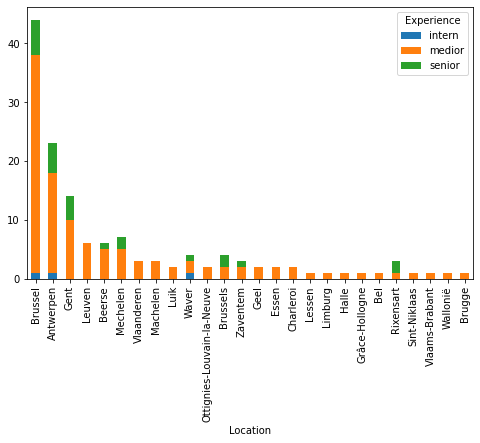

In [200]:
# Data Scientist 
dc = pd.DataFrame(dc_cards.groupby(["Location", "Experience"])["Experience"].count().sort_values(ascending=False))
dc = dc.rename(columns={"Experience" : "Count"})
dc = dc.reset_index()

dc_new = dc.pivot_table(values="Count", columns="Experience", aggfunc="first", index="Location")
dc_new.sort_values("medior", ascending=False).plot(kind="bar", stacked=True, figsize=(8, 5))

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='Location'>

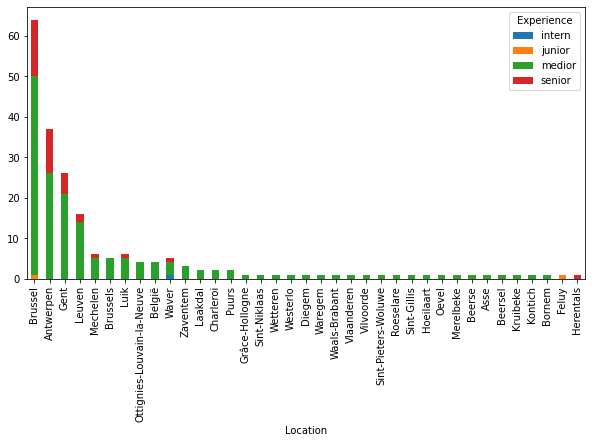

In [199]:
# Data Engineer
de = pd.DataFrame(de_cards.groupby(["Location", "Experience"])["Experience"].count().sort_values(ascending=False))
de = de.rename(columns={"Experience" : "Count"})
de = de.reset_index()

de_new = de.pivot_table(values="Count", columns="Experience", aggfunc="first", index="Location")
de_new.sort_values("medior", ascending=False).plot(kind="bar", stacked=True, figsize=(10, 5))

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='Location'>

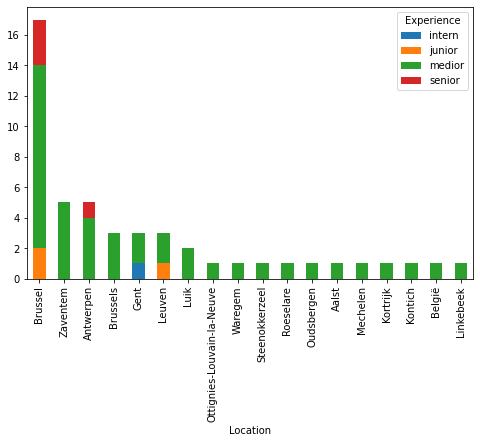

In [202]:
# Data Analyst 
da = pd.DataFrame(da_cards.groupby(["Location", "Experience"])["Experience"].count().sort_values(ascending=False))
da = da.rename(columns={"Experience" : "Count"})
da = da.reset_index()

da_new = da.pivot_table(values="Count", columns="Experience", aggfunc="first", index="Location")
da_new.sort_values("medior", ascending=False).plot(kind="bar", stacked=True, figsize=(8, 5))

### Create dataframe for Streamlit map

In [17]:
dc_cards.head(1)

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Company,Location,Description,Language,nlp_desc,nlp_desc_bi,nlp_desc_unique
0,senior consultant in data science ...,Sia Partners,Antwerpen,as a senior consultant in data science you wi...,en,"[senior, consultant, involve, transformation, ...","[senior_consultant, involve, transformation, p...","{project_assignment, commercial_initiativesas,..."


In [18]:
cities = pd.read_csv("E:/Projects/Job analysis/data/cities_be.csv")
dc_counts = pd.DataFrame(dc_cards.groupby(["Location"])["Title"].count().sort_values(ascending=False))
dc_counts.reset_index()
dc_counts_cities = dc_counts.merge(cities, left_on="Location", right_on="city")
dc_counts_cities.head()

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,23,Antwerpen,51.2206,4.4003,Belgium,BE,Flanders,minor,920000.0,459805.0
1,14,Gent,51.0536,3.7253,Belgium,BE,Flanders,minor,262219.0,262219.0
2,7,Mechelen,51.0281,4.4803,Belgium,BE,Flanders,minor,86921.0,86921.0
3,6,Leuven,50.8791,4.7009,Belgium,BE,Flanders,minor,NaN,NaN
4,4,Brussels,50.8333,4.3333,Belgium,BE,Brussels-Capital Region,primary,1743000.0,1019022.0


### Most frequent unique word counts in each job type

In [110]:
# Data Science

# Create 1 list of all unique words in english
dc_cards_en = dc_cards[dc_cards["Language"] == "en"]
dc_desc_list = [] 
dc_desc_list = [word for unique in dc_cards_en["nlp_desc_unique"] for word in list(unique)]

# Create df with word counts for all english job descriptions
dc_words = pd.DataFrame([word for l in dc_cards_en["nlp_desc_bi"] for word in l])
dc_freq = pd.DataFrame(dc_words.value_counts())
dc_freq.rename(columns={0:"counts"}, inplace=True)
dc_freq = dc_freq.reset_index()
dc_freq.rename(columns={0:"word"}, inplace=True)
dc_freq.sort_values(ascending=False, by=["counts"]).head(20)

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,word,counts
0,team,228
1,work,217
2,business,216
3,experience,213
4,project,191
5,development,129
6,skill,116
7,knowledge,115
8,analytics,113
9,develop,112


C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:ylabel='word'>

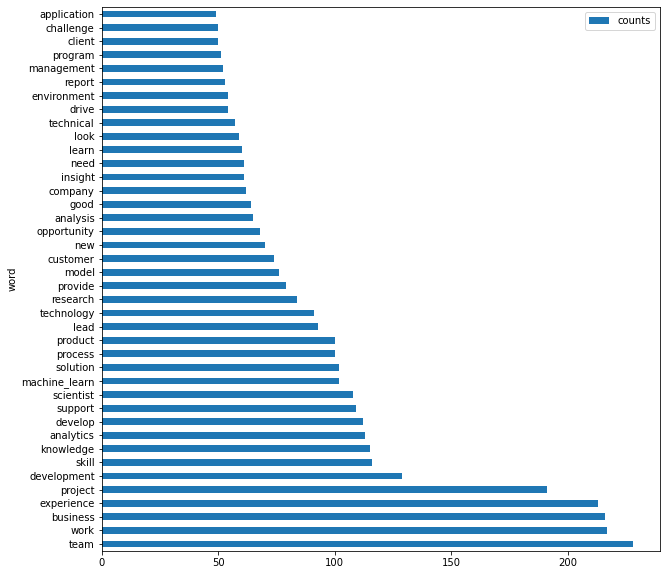

In [111]:
dc_freq[0:40].plot(kind="barh", x="word", y="counts", figsize=(10, 10))
# Clearly some words need to be put together as 1 word and simplified 
# (ex: "machine learning", "project and projects")

### Remove words with too low and high counts

In [101]:
dc_freq = dc_freq[(dc_freq["counts"] > 20) & (dc_freq["counts"] <130) ]

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create LDA model for the english version

In [112]:
# Filter too frequent words
desc_list_en = []
for word_l in dc_cards_en["nlp_desc_bi"]:
    filtered_l = [word for word in word_l if word in list(dc_freq["word"])]
    desc_list_en.append(filtered_l)
desc_list_en[0][0:5]

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['senior_consultant', 'involve', 'transformation', 'project', 'client']

In [113]:
# Create Variables for LDA 
id2word = gensim.corpora.Dictionary(desc_list_en)

corpus = []
for text in desc_list_en:
    new = id2word.doc2bow(text)
    corpus.append(new)

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [217]:
# Create LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=80,
                                            alpha=1e-15,
                                           minimum_probability=0.0)

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [218]:
t = lda_model.get_term_topics("python")
t

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(3, 0.0015654868), (8, 0.00152094), (11, 0.0010213372)]

In [219]:
# Visualize
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=15)
vis

C:\Users\maart\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.135409 -0.317477       1        1  35.020249
7     -0.123504 -0.317591       2        1  15.860863
11    -0.261029 -0.004289       3        1  10.416401
1     -0.128447  0.225197       4        1   6.984633
4      0.174373 -0.085732       5        1   6.060959
10     0.275918  0.076763       6        1   6.005720
3      0.068652  0.203463       7        1   5.610662
0     -0.080366 -0.081553       8        1   5.010799
5     -0.096956  0.086609       9        1   3.342224
6      0.003655  0.107386      10        1   2.108340
9      0.050538  0.061249      11        1   1.800212
2     -0.018244  0.045975      12        1   1.778938, topic_info=             Term        Freq       Total Category  logprob  loglift
188       product   81.000000   81.000000  Default  15.0000  15.0000
2829            ·   47.000000   47.000000  Default  14.0000  14.0000
9        business  147.000000  147.000000  Default  13.0000  13.0000
326     knowledge   99.000000   99.000000  Default  12.0000  12.0000
83        project  144.000000  144.000000  Default  11.0000  11.0000
...           ...         ...         ...      ...      ...      ...
1666   innovation    1.947293   34.074442  Topic12  -5.3797   1.1670
803   engineering    0.982837   14.688953  Topic12  -6.0635   1.3247
534      industry    1.032014   26.033768  Topic12  -6.0147   0.8013
271        create    0.977600   23.448532  Topic12  -6.0688   0.8517
69          learn    0.815056   38.349238  Topic12  -6.2507   0.1779

[341 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
1854      3  0.972329          120_country
1982      5  0.115720               2_year
1982      6  0.347161               2_year
1982      7  0.462882               2_year
1855      3  0.972329          3_developer
...     ...       ...                  ...
1578      7  0.899126                write
4368      4  0.895700  write_authorization
2829      2  0.977348                    ·
1020      2  0.613743                    …
1020     10  0.204581                    …

[519 rows x 3 columns], R=15, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 12, 2, 5, 11, 4, 1, 6, 7, 10, 3])